# Исследовательский анализ данных бронирования билетов на сервисе Яндекс Афиша с целью выявления инсайтов об изменении пользовательских предпочтений и популярности событий в осенний период 2024 года.

- Автор:Мусабаева Алеся Талгатовна
- Дата: 26.03.2025

Цель проекта: Целью данного проекта является проведение исследовательского анализа данных о заказах билетов на платформе Яндекс Афиша с целью выявления тенденций и изменений в поведении пользователей в осенний период 2024 года. Основные задачи проекта:

1. Загрузка данных и знакомство с ними 
2. Предобработка данных 
3. Исследовательский анализ данных 
4. Статистический анализ данных 
5. Общий вывод и рекомендации

Описание данных

Первый датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датасета соответствуют таблице purchases, с которой вы работали в предыдущих заданиях:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
В данные также был добавлен столбец `days_since_prev` с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Обратите внимание, что из данных исключили фильмы, ведь, как было видно на дашборде, событий такого типа не так много. Датасет содержит такие поля:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Третий датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).


## Загрузка данных и знакомство с ними

<font color='#777778'>

</font>

In [1]:
#Загружаем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
# Проведение U-теста (Mann-Whitney U-test)
from scipy.stats import mannwhitneyu

In [2]:
# Extract connection parameters
dbname = 'data-analyst-afisha'
user = 'praktikum_student'
password = 'Sdf4$2;d-d30pp'
host = 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net'
port = 6432

from sqlalchemy import create_engine

# Establish the connection
connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# Use pandas to read the purchase data
query_p= """
SELECT *,
       created_dt_msk::date - LAG(created_dt_msk) OVER(PARTITION BY user_id ORDER BY created_dt_msk)::date AS days_since_prev
FROM afisha.purchases
WHERE -- Фильтруем тип устройства
 device_type_canonical IN ('mobile',
                           'desktop'); 
"""
df_purchases = pd.read_sql_query(query_p, engine)


In [3]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

In [4]:
df_purchases.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


*Промежуточный вывод по данным:*

Объем данных:

В наборе данных 290849 записей (строк) и 14 колонок. Данные достаточно объемные, их обработка может потребовать определенных вычислительных ресурсов, особенно при использовании сложных операций или алгоритмов.

Типы данных:

- Целочисленные данные: `order_id`, `event_id`, `age_limit`, `tickets_count` — подходят для анализа категориальных переменных или количественных значений.

- Числовые данные с плавающей запятой: `revenue`, `total`, `days_since_prev` — эти колонки могут потребовать дополнительной обработки для исключения аномальных значений.

- Объектные данные: `user_id`, `cinema_circuit`, `currency_code`, d`evice_type_canonical`, `service_name` — строки, которые могут быть полезны для категоризации и анализа распределения.

- Дата/время: `created_dt_msk`, `created_ts_msk` — данные о времени, которые, возможно, потребуют извлечения информации о днях недели, месяцах или часах для дальнейшего анализа.

Наличие пропусков:

- Пропуски есть только в колонке `days_since_prev` (268909 значений против 290849, то есть 21940 значений пропущено). Это может быть связано с отсутствием предыдущих заказов для некоторых пользователей или событий. Пропуски в этой колонке потребуют обработки.

Предположения для предобработки данных:

- Для колонок с количественными данными (например, `revenue`, `total`) следует проверить наличие аномальных значений или выбросов, которые могут исказить результаты анализа.

- Проверить данные на наличие дублированных записей.


In [5]:
# Use pandas to read the purchase data
query_e= """
SELECT -- Выгружаем данные таблицы events:
 e.event_id,
 e.event_name_code AS event_name,
 e.event_type_description,
 e.event_type_main,
 e.organizers, 
 -- Выгружаем информацию о городе и регионе:
 r.region_name,
 c.city_name,
 c.city_id, 
 -- Выгружаем информацию о площадке:
 v.venue_id,
 v.venue_name,
 v.address AS venue_address
FROM afisha.events AS e
LEFT JOIN afisha.venues AS v USING(venue_id)
LEFT JOIN afisha.city AS c USING(city_id)
LEFT JOIN afisha.regions AS r USING(region_id)
WHERE e.event_id IN
    (SELECT DISTINCT event_id
     FROM afisha.purchases
     WHERE -- Фильтруем тип устройства
 device_type_canonical IN ('mobile',
                           'desktop'))
  AND e.event_type_main != 'фильм';
"""
df_events = pd.read_sql_query(query_e, engine)

In [6]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [7]:
df_events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


*Промежуточный вывод по данным:*

Объем данных:

- В наборе данных 22,427 записей (строк) и 11 колонок. 

Типы данных:

- Целочисленные данные: `event_id`, `city_id`, `venue_id` — данные типа int64, которые могут быть использованы для идентификации мероприятий, городов и мест.

- Объектные данные: `event_name`, `event_type_description`, `event_type_main`, `organizers`, `region_name`, `city_name`, `venue_name`, `venue_address` — строки, которые описывают различные аспекты мероприятия и его места проведения.

Наличие пропусков:

- Все колонки содержат полные данные (Non-Null Count равен количеству записей, то есть 22,427). Это означает, что данные не содержат пропусков.

Предположения для предобработки данных:

- Стоит проверить колонки, такие как event_type_main, чтобы убедиться, что все категории в этих столбцах имеют смысл и не содержат ошибок ввода.

- Необходимо проверить, есть ли дублированные записи, особенно для идентификаторов (`event_id`, `city_id`, `venue_id`), чтобы избежать повторяющихся мероприятий или мест.



In [8]:
df_tenge=pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
# Преобразуем колонку 'data' в тип datetime
df_tenge['data'] = pd.to_datetime(df_tenge['data'], errors='coerce')
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [9]:
df_tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


*Промежуточный вывод по данным:*

- В наборе данных 357 записей (строк) и 4 колонки. Это относительно небольшой объем данных, что указывает на ограниченный набор информации.
- Все колонки содержат полные данные (Non-Null Count равен 357 для всех), то есть пропусков нет.
- Преобразовать data в тип datetime, если это дата.

## Предобработка данных и подготовка их к исследованию

<font color='#777778'>

Рекомендация: вначале можно объединить данные в один датафрейм, а затем провести общую предобработку.
После предобработки проверьте, сколько данных вы отобрали, если выполняли фильтрацию, а также дайте промежуточный вывод с основными действиями и описанием новых столбцов.
</font>

In [10]:
# 1. Объединение orders_df и events_df по 'event_id'
df = pd.merge(df_purchases, df_events, on='event_id', how='right')



### Проверьте данные на пропуски. Проверьте, что выгрузка данных из SQL была успешной — кроме столбца days_since_prev данные не должны содержать пропусков.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

*Отобрали только данные, которые находятся во всех датасетах. Остались пропуски только постолбцу `days_since_prevz`*

### Изучите значения в ключевых столбцах и при обнаружении ошибок обработайте их.
Для категориальных значений изучите, какие категории присутствуют в данных. Проверьте, встречаются ли значения, которые могут обозначать пропуски в данных или отсутствие информации. Проведите нормализацию данных, если это необходимо.

Для количественных значений посмотрите на распределение и наличие выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха. Для анализа данных важными показателями являются выручка с заказа revenue и количество билетов в заказе tickets_count, поэтому в первую очередь проверьте данные в этих столбцах. Если найдутся выбросы в выручке с заказа revenue, то отберите значения по 99-му процентилю. Не забудьте, что данные изначально были представлены в разных валютах, поэтому разделите анализ на рубли и тенге.

*Анализ категориальных значений*

In [12]:
# Проверим уникальные значения для категориальных столбцов
categorical_columns = ['cinema_circuit', 'age_limit','currency_code', 'device_type_canonical', 
                       'service_name',  'event_type_description', 
                       'event_type_main', 'organizers', 'region_name', 
                       'city_name', 'venue_name', 'venue_address']

for col in categorical_columns:
    print(f"Уникальные значения в столбце {col}:")
    print(df[col].unique())
    print()


Уникальные значения в столбце cinema_circuit:
['нет' 'Другое' 'КиноСити' 'Москино' 'Киномакс' 'ЦентрФильм']

Уникальные значения в столбце age_limit:
[16  6 12 18  0]

Уникальные значения в столбце currency_code:
['rub' 'kzt']

Уникальные значения в столбце device_type_canonical:
['mobile' 'desktop']

Уникальные значения в столбце service_name:
['Лови билет!' 'Прачечная' 'Crazy ticket!' 'Облачко' 'Билеты в руки'
 'За билетом!' 'Билеты без проблем' 'Яблоко' 'Весь в билетах'
 'Дом культуры' 'Край билетов' 'Городской дом культуры' 'Show_ticket'
 'Тебе билет!' 'Вперёд!' 'Лучшие билеты' 'Мир касс' 'Выступления.ру'
 'Быстробилет' 'Мой билет' 'Росбилет' 'Цвет и билет' 'Тех билет'
 'Быстрый кассир' 'КарандашРУ' 'Шоу начинается!' 'Восьмёрка' 'Реестр'
 'Телебилет' 'Зе Бест!' 'Билет по телефону' 'Лимоны' 'Радио ticket'
 'Кино билет' 'Дырокол' 'Билеты в интернете']

Уникальные значения в столбце event_type_description:
['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'с

In [13]:
# Переименовываем категорию 'спорт' в 'спортивное мероприятие'
df['event_type_description'] = df['event_type_description'].replace('спорт', 'спортивное мероприятие')

*Анализ количественных значений*

In [14]:
df[['revenue', 'tickets_count']].describe()

,revenue,tickets_count
count,290611.000000,290611.000000
mean,625.584360,2.754311
std,1227.693064,1.170620
min,-90.760000,1.000000
25%,116.850000,2.000000
50%,356.010000,3.000000
75%,810.130000,4.000000
max,81174.540000,57.000000


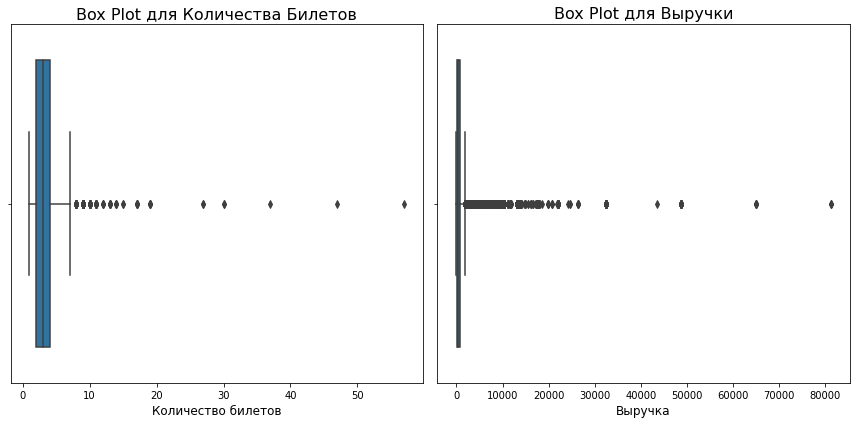

In [15]:
# Создание фигуры с двумя подграфиками (1 строка, 2 столбца)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Построение box plot для 'tickets_count'
sns.boxplot(x=df['tickets_count'], ax=axes[0])
axes[0].set_title('Box Plot для Количества Билетов', fontsize=16)
axes[0].set_xlabel('Количество билетов', fontsize=12)

# Построение box plot для 'revenue'
sns.boxplot(x=df['revenue'], ax=axes[1])
axes[1].set_title('Box Plot для Выручки', fontsize=16)
axes[1].set_xlabel('Выручка', fontsize=12)

# Показываем график
plt.tight_layout()  # Автоматически регулирует расстояние между графиками
plt.show()

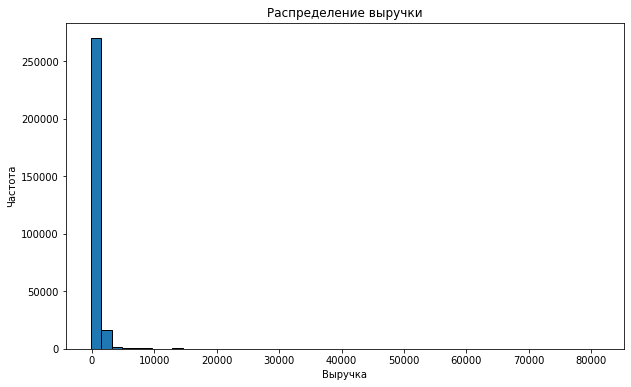

In [16]:
# Анализ распределения всей выручки
plt.figure(figsize=(10, 6))
plt.hist(df['revenue'], bins=50, edgecolor='black')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()





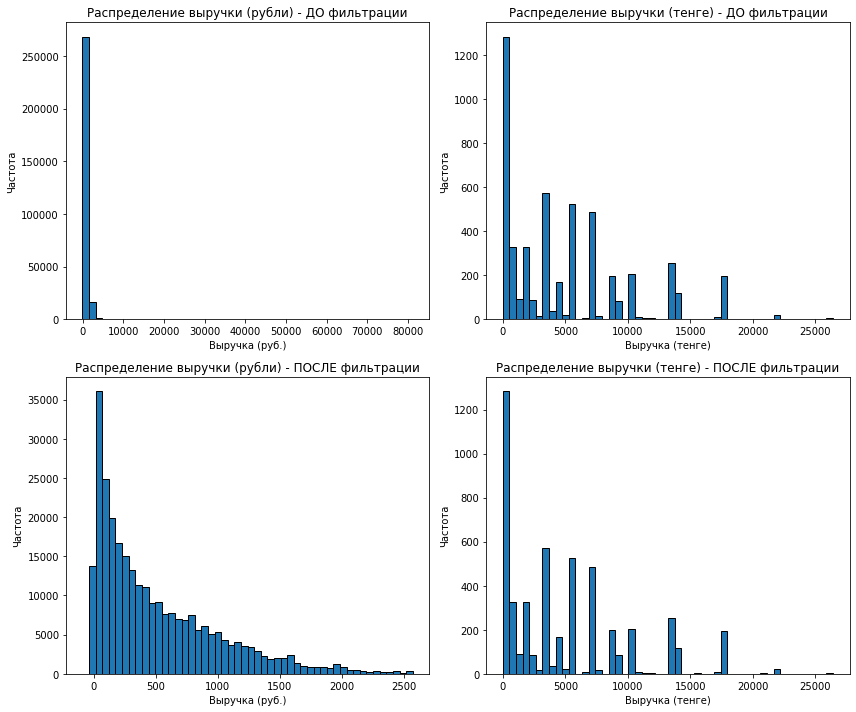

99-й процентиль выручки (руб.): 2570.80


In [17]:
# 1. Разделяем данные на рубли и тенге
df_rub = df[df['currency_code'] == 'rub']
df_kzt = df[df['currency_code'] == 'kzt']

# 2. Рассчитываем 99-й процентиль для рублей
revenue_rub_percentile_99 = np.percentile(df_rub['revenue'], 99)

# 3. Фильтруем выбросы только в рублях, оставляя тенге без изменений
df = df[
    (df['currency_code'] == 'kzt') | (df['revenue'] <= revenue_rub_percentile_99)
]

df_rub_filtered = df[df['currency_code'] == 'rub']
df_kzt_filtered = df[df['currency_code'] == 'kzt']

# 4. Строим графики распределения выручки ДО и ПОСЛЕ фильтрации
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# До фильтрации (Рубли)
axes[0, 0].hist(df_rub['revenue'], bins=50, edgecolor='black')
axes[0, 0].set_title('Распределение выручки (рубли) - ДО фильтрации')
axes[0, 0].set_xlabel('Выручка (руб.)')
axes[0, 0].set_ylabel('Частота')

# До фильтрации (Тенге)
axes[0, 1].hist(df_kzt['revenue'], bins=50, edgecolor='black')
axes[0, 1].set_title('Распределение выручки (тенге) - ДО фильтрации')
axes[0, 1].set_xlabel('Выручка (тенге)')
axes[0, 1].set_ylabel('Частота')

# После фильтрации (Рубли)
axes[1, 0].hist(df_rub_filtered['revenue'], bins=50, edgecolor='black')
axes[1, 0].set_title('Распределение выручки (рубли) - ПОСЛЕ фильтрации')
axes[1, 0].set_xlabel('Выручка (руб.)')
axes[1, 0].set_ylabel('Частота')

# После фильтрации (Тенге) - не изменилось, но строим для наглядности
axes[1, 1].hist(df_kzt_filtered['revenue'], bins=50, edgecolor='black')
axes[1, 1].set_title('Распределение выручки (тенге) - ПОСЛЕ фильтрации')
axes[1, 1].set_xlabel('Выручка (тенге)')
axes[1, 1].set_ylabel('Частота')

# Расставляем подписи и компоновку
plt.tight_layout()
plt.show()

# Выводим статистику
print(f"99-й процентиль выручки (руб.): {revenue_rub_percentile_99:.2f}")

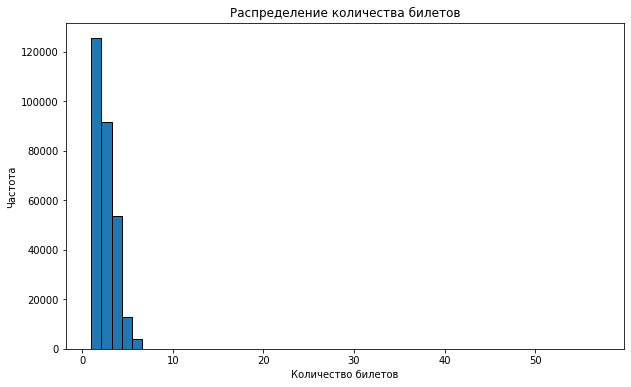

In [18]:
# Анализ распределения количества билетов
plt.figure(figsize=(10, 6))
plt.hist(df['tickets_count'], bins=50, edgecolor='black')
plt.title('Распределение количества билетов')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.show()


*Промежуточные выводы*:

Категории:
- В столбце cinema_circuit встречается значение 'нет', которое может означать отсутствие информации о кинотеатральной сети.

- Также важно учитывать, что в столбцах с географическими данными могут встречаться дубликаты или не вполне стандартные названия мест (например, возможные опечатки в city_name и venue_name).

Количественные значения:
- Средние значения по обеим колонкам показывают, что для большинства записей характерно небольшое количество билетов (около 3) и умеренные доходы (около 625), но также есть экстремальные значения (высокие доходы и большое количество билетов).
- Это может указывать на несколько типов пользователей или бизнес-ситуаций (например, с огромными заказами или ошибками в данных).


### Проверьте явные и неявные дубликаты. Сделайте акцент на неявных дубликатах по бронированию билета без учёта идентификаторов заказа и, если такие будут, примите обоснованное решение, как их стоит обработать.

In [19]:
# 1. Проверка явных дубликатов
duplicates = df[df.duplicated()]  # Находит явные дубликаты
display("Явные дубликаты:")
print(duplicates)

'Явные дубликаты:'

Empty DataFrame
Columns: [order_id, user_id, created_dt_msk, created_ts_msk, event_id, cinema_circuit, age_limit, currency_code, device_type_canonical, revenue, service_name, tickets_count, total, days_since_prev, event_name, event_type_description, event_type_main, organizers, region_name, city_name, city_id, venue_id, venue_name, venue_address]
Index: []

[0 rows x 24 columns]


In [20]:
# 2. Проверка неявных дубликатов
# Для проверки неявных дубликатов исключаем столбец 'order_id' и ищем дубликаты по остальным признакам
non_explicit_duplicates = df.drop(columns='order_id').duplicated()
display("\nНеявные дубликаты:")
display(df[non_explicit_duplicates])

'\nНеявные дубликаты:'

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
13940,589252,e333b28575ed7f9,2024-07-28,2024-07-28 12:50:38,81165,нет,12,rub,mobile,40.84,...,3989adcc-5d67-4a18-a741-6118a6568172,спектакль,театр,№3902,Солнечноземская область,Глинополье,56,3005,"Арт-кафе ""Аксессуар"" Лимитед","бул. Логовой, д. 94 к. 1/5"
23715,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
38968,8248210,8f95286aa5fd8d7,2024-06-20,2024-06-20 10:57:19,244875,нет,0,rub,mobile,15.73,...,61f8b9bd-a66f-4cd9-ae10-a0e62e923476,выставка,другое,№3906,Каменноозёрный край,Ордакент,12,2492,"Кинофестиваль ""Хранитель"" Инкорпорэйтед","пр. Балтийский, д. 8 к. 51"
45430,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76,3094,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2"
50523,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2,2795,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"
50527,5373179,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2,2795,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"
77897,2768051,c2c6d35ff678ca6,2024-08-06,2024-08-06 13:26:42,379268,нет,0,rub,mobile,87.02,...,b16a8d23-6085-4b04-8b8a-35b74a3d89f2,событие,другое,№2685,Североярская область,Озёрск,2,1283,"Клуб начинающих писателей ""Детство"" Лимитед","ул. Заозерная, д. 9"
77899,2767964,c2c6d35ff678ca6,2024-08-06,2024-08-06 13:26:42,379268,нет,0,rub,mobile,108.77,...,b16a8d23-6085-4b04-8b8a-35b74a3d89f2,событие,другое,№2685,Североярская область,Озёрск,2,1283,"Клуб начинающих писателей ""Детство"" Лимитед","ул. Заозерная, д. 9"
88301,6431070,9103be7b790235f,2024-08-03,2024-08-03 15:01:56,410465,нет,0,rub,mobile,685.12,...,ca2f9e9a-313d-404b-9c35-074e7a238df7,шоу,другое,№3287,Каменевский регион,Глиногорск,213,3391,"Театральные мастерские ""Сюжет"" Инк","бул. Володарского, д. 237 стр. 9/3"
91471,6657995,7eb4fc207ecc10f,2024-10-26,2024-10-26 09:39:03,418836,нет,0,rub,mobile,294.85,...,a4478837-4631-4e28-95d7-a4c26751a232,цирковое шоу,другое,№1703,Тепляковская область,Горнодолинск,43,4481,"Школа сценического мастерства ""Вдох"" Лтд","пер. Полярный, д. 87"


In [21]:
# 1. Создаём копию датафрейма без 'order_id'
df_no_order_id = df.drop(columns='order_id')

# 2. Подсчитываем количество строк до удаления дубликатов
total_rows_before = len(df_no_order_id)

# 3. Удаляем дубликаты в df_no_order_id
df_no_duplicates = df_no_order_id.drop_duplicates(keep='first')

# 4. Подсчитываем количество строк после удаления дубликатов
total_rows_after = len(df_no_duplicates)

# 5. Количество удалённых дубликатов
duplicates_removed = total_rows_before - total_rows_after

# Выводим результат
display(f"Количество удалённых дубликатов: {duplicates_removed}")
df_no_duplicates.shape[0]

'Количество удалённых дубликатов: 30'

287781

*Промежуточные выводы*:
- Явных дубликатов не обнаружено
- Неявные дубликаты удалены(30), order_id оставлено первое значение 

### Проведите преобразования типов данных. Обратите внимание на типы данных с датой и временем, а также проверьте возможность снижения размерности количественных данных.

In [22]:
# Применим типизацию для всех числовых столбцов (int64, float64)
def optimize_numeric_types(df):
    for col in df.select_dtypes(include=['int64', 'float64']):
        # Если столбец содержит целые числа
        if df[col].dtype == 'int64':
            # Пробуем преобразовать в более компактные типы
            min_val, max_val = df[col].min(), df[col].max()
            if min_val >= -2**7 and max_val <= 2**7 - 1:
                df[col] = df[col].astype('int8')
            elif min_val >= -2**15 and max_val <= 2**15 - 1:
                df[col] = df[col].astype('int16')
            elif min_val >= -2**31 and max_val <= 2**31 - 1:
                df[col] = df[col].astype('int32')
            else:
                df[col] = df[col].astype('int64')
        # Если столбец содержит вещественные числа
        elif df[col].dtype == 'float64':
            # Преобразуем в float32 для экономии памяти, если возможно
            df[col] = df[col].astype('float32')
    return df

# Преобразуем категориальные столбцы в pd.Categorical
def optimize_categorical_types(df):
    for col in df.select_dtypes(include=['object']):
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        # Если уникальных значений мало по сравнению с общим количеством
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    return df

# Применяем обе оптимизации
df = optimize_numeric_types(df)
df = optimize_categorical_types(df)

# Проверяем результат
display(df.dtypes)

order_id                           int32
user_id                         category
created_dt_msk            datetime64[ns]
created_ts_msk            datetime64[ns]
event_id                           int32
cinema_circuit                  category
age_limit                           int8
currency_code                   category
device_type_canonical           category
revenue                          float32
service_name                    category
tickets_count                       int8
total                            float32
days_since_prev                  float32
event_name                      category
event_type_description          category
event_type_main                 category
organizers                      category
region_name                     category
city_name                       category
city_id                            int32
venue_id                           int16
venue_name                      category
venue_address                   category
dtype: object

*Промежуточные выводы*:

Типы данных:
- Оптимизация типов данных позволила существенно уменьшить объем памяти, который занимают данные.

- Работа с данными стала более быстрой и эффективной, особенно при анализе больших объемов информации.
- Есть значительные выбросы как по доходам, так и по количеству билетов, особенно по доходам (включая отрицательные значения).


### Создайте несколько новых столбцов:
revenue_rub — приведите выручку с заказа к единой валюте — российскому рублю. Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю final_tickets_tenge_df.csv за 2024 год. Значения в рублях представлены для 100 тенге.
one_ticket_revenue_rub — рассчитайте выручку с продажи одного билета на мероприятие.
month — выделите месяц оформления заказа в отдельный столбец.
season — создайте столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [23]:
# Мы соединяем по дате, где дата из основного датафрейма (created_dt_msk) должна совпадать с датой в df_tenge
df = pd.merge(df, df_tenge[['data', 'curs']], left_on='created_dt_msk', right_on='data', how='left')

# Теперь, создаем столбец revenue_rub в зависимости от валюты
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub' 
    else row['revenue'] * row['curs'] / 100 if row['currency_code'] == 'kzt' 
    else row['revenue'], axis=1)

# Удаляем лишние столбцы после слияния, если они не нужны
df.drop(columns=['data', 'curs'], inplace=True)

# Проверим результат
# Фильтруем строки с валютой 'rub' и 'kzt'
rub_rows = df[df['currency_code'] == 'rub'].head(5)
kzt_rows = df[df['currency_code'] == 'kzt'].head(5)

# Выводим результаты
display("Первые 5 строк с валютой 'rub':")
display(rub_rows[['order_id', 'currency_code', 'revenue', 'revenue_rub', 'created_dt_msk']])

display("\nПервые 5 строк с валютой 'kzt':")
display(kzt_rows[['order_id', 'currency_code', 'revenue', 'revenue_rub', 'created_dt_msk']])

"Первые 5 строк с валютой 'rub':"

,order_id,currency_code,revenue,revenue_rub,created_dt_msk
0,4477195,rub,212.039993,212.039993,2024-10-27
1,4477166,rub,424.079987,424.079987,2024-10-27
2,4477137,rub,424.079987,424.079987,2024-10-27
3,4477108,rub,424.079987,424.079987,2024-10-27
4,544911,rub,212.039993,212.039993,2024-09-17


"\nПервые 5 строк с валютой 'kzt':"

,order_id,currency_code,revenue,revenue_rub,created_dt_msk
8524,2891098,kzt,1131.380005,224.712434,2024-06-09
22519,4974371,kzt,1485.640015,296.037543,2024-10-28
22520,3768928,kzt,594.260010,111.048180,2024-09-03
22521,3768841,kzt,594.260010,111.048180,2024-09-03
22522,8135458,kzt,594.260010,113.623702,2024-08-25


In [24]:
# Рассчитываем выручку с продажи одного билета с учетом выручки в рублях
df['one_ticket_revenue'] = df.apply(
    lambda row: row['revenue_rub'] / row['tickets_count'] if row['tickets_count'] > 0 else 0,
    axis=1
)

# Проверим результат
display(df[['order_id', 'revenue_rub', 'tickets_count', 'one_ticket_revenue']].head())


,order_id,revenue_rub,tickets_count,one_ticket_revenue
0,4477195,212.039993,1,212.039993
1,4477166,424.079987,2,212.039993
2,4477137,424.079987,2,212.039993
3,4477108,424.079987,2,212.039993
4,544911,212.039993,1,212.039993


In [25]:
# Выделяем месяц оформления заказа в отдельный столбец
df['month'] = df['created_dt_msk'].dt.month

# Проверим результат
display(df['month'].unique())


array([10,  9,  8,  7,  6])

In [26]:
# Функция для определения сезона
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

# Создаем столбец season
df['season'] = df['month'].apply(get_season)

# Проверим результат
display(df[['order_id', 'month', 'season']].head())


,order_id,month,season
0,4477195,10,Осень
1,4477166,10,Осень
2,4477137,10,Осень
3,4477108,10,Осень
4,544911,9,Осень


Мы добавили 4 новых столбца в датафрейм:

- `revenue_rub` — выручка с заказа, приведенная к российскому рублю, с учетом курса тенге к рублю (для валюты kzt).

- `one_ticket_revenue` — выручка с продажи одного билета, рассчитанная как отношение общей выручки (revenue_rub) к количеству проданных билетов (tickets_count).

- `month` — месяц оформления заказа, извлеченный из столбца с датой (created_dt_msk).

- `season` — сезон, соответствующий месяцу оформления заказа, определенный на основе числового значения месяца (лето, осень, зима, весна).

Эти столбцы позволяют более детально анализировать данные, включая выручку в рублях, выручку на билет, время заказа и сезонность.

### Промежуточный вывод 2 раздела:


- Категории:

В столбце cinema_circuit встречается значение 'нет', что может означать отсутствие информации о кинотеатральной сети.

В столбцах с географическими данными могут присутствовать дубликаты или нетипичные (возможно, ошибочные) названия мест, таких как city_name и venue_name.

Количественные значения:

- Средние значения для количества билетов (около 3) и выручки (около 625) указывают на то, что для большинства записей характерны небольшие заказы с умеренными доходами.

- Однако существуют экстремальные значения, включая высокие доходы и большое количество билетов, что может быть связано с особенностями пользователей (например, крупные заказы) или ошибками в данных.

Дубликаты:

- Явных дубликатов в данных не обнаружено.

- Неявные дубликаты были удалены (30 записей), при этом оставлено первое значение для каждого order_id.

Типы данных:

Оптимизация типов данных значительно снизила объем памяти, необходимый для хранения данных, что сделало работу с ними более быстрой и эффективной, особенно при анализе больших объемов информации.

Выбросы:

Обнаружены значительные выбросы по доходам и количеству билетов, особенно по доходам, включая отрицательные значения. Эти выбросы могут быть связаны с ошибками в данных или необычными ситуациями.

Новые столбцы:

- `revenue_rub` — выручка, приведенная к российскому рублю с учетом курса тенге (для валюты kzt).

- `one_ticket_revenue` — выручка с продажи одного билета, рассчитанная как отношение общей выручки (revenue_rub) к количеству билетов (tickets_count).
- `month` — месяц оформления заказа, извлеченный из столбца created_dt_msk.
- `season` — сезон, соответствующий месяцу оформления заказа, определенный на основе месяца (лето, осень, зима, весна).


## Исследовательский анализ данных

<font color='#777778'>

</font>

Анализ дашборда показал, что в данных наблюдается сезонность — осенью количество заказов увеличивается. На стадии исследовательского анализа изучите изменение пользовательской активности или пользовательского интереса в связи с сезонностью. Анализируйте динамику по таким разрезам:
тип мероприятия event_type_main;
тип устройства device_type_canonical;
категория мероприятий по возрастному рейтингу age_limit.
В этом разделе изучите распределение заказов по сегментам и их сезонные изменения, выполнив следующие шаги:

### Анализ распределения заказов по сегментам и их сезонные изменения

Для каждого месяца найдите количество заказов и визуализируйте результаты. Проверьте, фиксируется ли увеличение заказов от июня к ноябрю 2024 года.

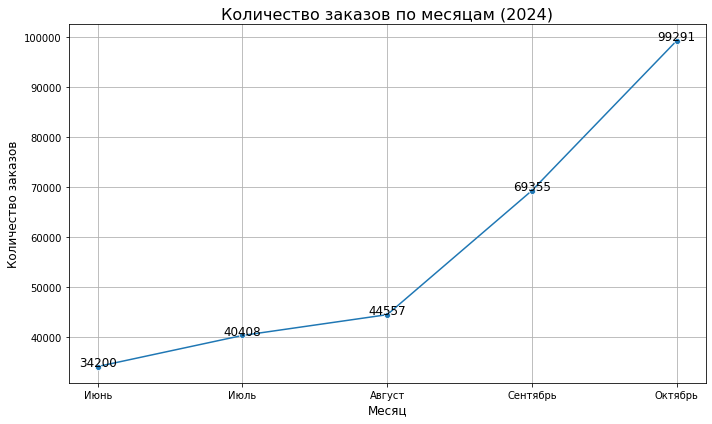

month
6     34200
7     40408
8     44557
9     69355
10    99291
Name: order_id, dtype: int64

'\nПроцентное увеличение с июня по ноябрь 2024:'

month
6       nan%
7     18.15%
8     10.27%
9     55.65%
10    43.16%
Name: order_id, dtype: object

In [27]:
# Группируем данные по месяцам и считаем количество заказов
monthly_orders = df.groupby('month')['order_id'].count()

# Рассчитываем процентное изменение от месяца к месяцу
monthly_orders_pct_change = monthly_orders.pct_change() * 100  # Процентное изменение

# Визуализируем результат
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_orders.index, y=monthly_orders.values, marker='o')

# Добавляем аннотации для каждого значения
for i in range(len(monthly_orders)):
    plt.text(monthly_orders.index[i], monthly_orders.values[i] + 10, str(monthly_orders.values[i]), ha='center', fontsize=12)

# Настроим график
plt.title('Количество заказов по месяцам (2024)', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)

# Получаем уникальные месяцы, которые присутствуют в данных
month_labels = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
filtered_month_labels = [month_labels[i-1] for i in monthly_orders.index]

# Устанавливаем метки на оси X
plt.xticks(monthly_orders.index, filtered_month_labels)

plt.grid(True)
plt.tight_layout()

# Показать график
plt.show()

# Проверим, фиксируется ли увеличение заказов от июня к ноябрю 2024 года
orders_june_to_november = monthly_orders.loc[6:11]  # Месяцы с июня по ноябрь (6,7,8,...,11)
display(orders_june_to_november)

# Проверяем процентное увеличение
pct_change_june_to_november = monthly_orders_pct_change.loc[6:11]
display("\nПроцентное увеличение с июня по ноябрь 2024:")
# Добавим знак процента в вывод
display(pct_change_june_to_november.apply(lambda x: f'{x:.2f}%'))

*Промежуточный вывод*

- Мы видим четкую тенденцию к увеличению заказов от июня к ноябрю, что может указывать на рост спроса на билеты в это время.

- Этот анализ поможет нам понять сезонные колебания и выявить возможные тренды в спросе на события, а также позволяет прогнозировать увеличение продаж в определенные месяцы.

Для осеннего и летнего периодов сравните распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу. Результаты визуализируйте подходящим графиком, который поможет сопоставить значения для летнего и осеннего сезонов. Рекомендация: поскольку абсолютное количество заказов в разные сезоны может меняться, при сопоставлении результатов для каждого сегмента используйте доли.

               Лето      Осень
концерты  42.628289  37.203966
другое    27.169051  19.703995
театр     20.097344  25.341247
стендап    5.325389   4.105048
спорт      2.522553  11.198605
выставки   2.028280   1.444446
ёлки       0.229094   1.002692


<Figure size 720x432 with 0 Axes>

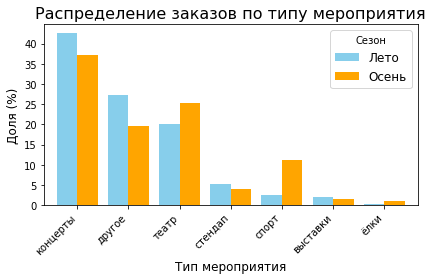

In [28]:
# Фильтруем данные для летнего и осеннего сезонов
summer_df = df[df['season'] == 'Лето']
autumn_df = df[df['season'] == 'Осень']

# Создаем сводную таблицу по типу мероприятия для летнего сезона
summer_event_type_pivot = summer_df['event_type_main'].value_counts(normalize=True) * 100

# Создаем сводную таблицу по типу мероприятия для осеннего сезона
autumn_event_type_pivot = autumn_df['event_type_main'].value_counts(normalize=True) * 100

# Объединяем данные по летнему и осеннему сезонам в одну таблицу, используя reindex для согласования индексов
event_type_comparison = pd.DataFrame({
    'Лето': summer_event_type_pivot,
    'Осень': autumn_event_type_pivot
}).fillna(0)  # Заполняем пропуски нулями для категорий, которые не встречаются в одном из сезонов

# Сортируем по индексу по убыванию
event_type_comparison = event_type_comparison.sort_values(by=['Лето', 'Осень'], ascending=False)

# Печатаем сводную таблицу для проверки
print(event_type_comparison)

# Визуализируем результат с помощью столбчатой диаграммы
plt.figure(figsize=(10, 6))
event_type_comparison.plot(kind='bar', color=['skyblue', 'orange'], width=0.8)
plt.title('Распределение заказов по типу мероприятия', fontsize=16)
plt.xlabel('Тип мероприятия', fontsize=12)
plt.ylabel('Доля (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Сезон', fontsize=12)
plt.tight_layout()

plt.show()


              Лето      Осень
mobile   80.630219  79.656796
desktop  19.369781  20.343204


<Figure size 720x432 with 0 Axes>

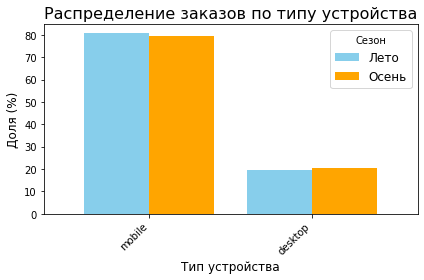

In [29]:
# Создаем сводную таблицу по типу устройства для летнего сезона
summer_device_type_pivot = summer_df['device_type_canonical'].value_counts(normalize=True) * 100

# Создаем сводную таблицу по типу устройства для осеннего сезона
autumn_device_type_pivot = autumn_df['device_type_canonical'].value_counts(normalize=True) * 100

# Объединяем данные по летнему и осеннему сезонам в одну таблицу
device_type_comparison = pd.DataFrame({
    'Лето': summer_device_type_pivot,
    'Осень': autumn_device_type_pivot
})

# Печатаем сводную таблицу для проверки
print(device_type_comparison)

# Визуализируем результат с помощью столбчатой диаграммы
plt.figure(figsize=(10, 6))
device_type_comparison.plot(kind='bar', color=['skyblue', 'orange'], width=0.8)
plt.title('Распределение заказов по типу устройства', fontsize=16)
plt.xlabel('Тип устройства', fontsize=12)
plt.ylabel('Доля (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Сезон', fontsize=12)
plt.tight_layout()

plt.show()


         Лето      Осень
16  28.327949  26.219418
12  20.554693  22.097767
6   18.189905  17.625084
0   17.965007  23.619890
18  14.962447  10.437840


<Figure size 720x432 with 0 Axes>

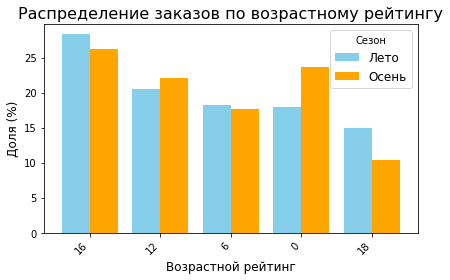

In [30]:
# Создаем сводную таблицу по возрастному рейтингу для летнего сезона
summer_age_limit_pivot = summer_df['age_limit'].value_counts(normalize=True) * 100

# Создаем сводную таблицу по возрастному рейтингу для осеннего сезона
autumn_age_limit_pivot = autumn_df['age_limit'].value_counts(normalize=True) * 100

# Объединяем данные по летнему и осеннему сезонам в одну таблицу, используя reindex для согласования индексов
age_limit_comparison = pd.DataFrame({
    'Лето': summer_age_limit_pivot,
    'Осень': autumn_age_limit_pivot
}).fillna(0)  # Заполняем пропуски нулями для категорий, которые не встречаются в одном из сезонов

# Сортируем по индексу по убыванию
age_limit_comparison = age_limit_comparison.sort_values(by=['Лето', 'Осень'], ascending=False)

# Печатаем сводную таблицу для проверки
print(age_limit_comparison)

# Визуализируем результат с помощью столбчатой диаграммы
plt.figure(figsize=(10, 6))
age_limit_comparison.plot(kind='bar', color=['skyblue', 'orange'], width=0.8)
plt.title('Распределение заказов по возрастному рейтингу', fontsize=16)
plt.xlabel('Возрастной рейтинг', fontsize=12)
plt.ylabel('Доля (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Сезон', fontsize=12)
plt.tight_layout()

plt.show()



*Промежуточные выводы*

- Концерты и стендап теряют популярность осенью, что может быть связано с уменьшением открытых мероприятий и сезонными предпочтениями аудитории.

- Спортивные мероприятия становятся более популярными осенью.

- На мобильных устройствах делается основная часть заказов в обоих сезонах, но осенью доля десктопных пользователей немного увеличивается.

- Возрастной рейтинг 16 и 12 лет остаются ключевыми для обоих сезонов, с небольшими колебаниями интереса в зависимости от сезона.

Изучите изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. Видна ли динамика средней стоимости билета в разрезе разных категорий мероприятий? Для каждого типа мероприятия рассчитайте среднее значение выручки с одного билета, затем найдите относительное изменение осенних значений по сравнению с летними. Результат сопроводите подходящей визуализацией.

In [31]:
# Рассчитываем среднюю выручку с одного билета по типам мероприятий для летнего сезона
summer_revenue_by_event_type = summer_df.groupby('event_type_main')['one_ticket_revenue'].mean()

# Рассчитываем среднюю выручку с одного билета по типам мероприятий для осеннего сезона
autumn_revenue_by_event_type = autumn_df.groupby('event_type_main')['one_ticket_revenue'].mean()

# Создаем сводную таблицу
revenue_comparison = pd.DataFrame({
    'Лето': summer_revenue_by_event_type,
    'Осень': autumn_revenue_by_event_type
})

# Рассчитываем относительное изменение выручки для каждого типа мероприятия
revenue_comparison['Относительное изменение (%)'] = ((revenue_comparison['Осень'] - revenue_comparison['Лето']) / revenue_comparison['Лето']) * 100

# Сортируем по абсолютному изменению выручки для выделения значимых изменений
revenue_comparison = revenue_comparison.sort_values(by='Относительное изменение (%)', ascending=False)

# Выводим сводную таблицу с относительным изменением
display("Сводная таблица с относительным изменением выручки с одного билета по типам мероприятий для летнего и осеннего сезонов:")
display(revenue_comparison)



'Сводная таблица с относительным изменением выручки с одного билета по типам мероприятий для летнего и осеннего сезонов:'

,Лето,Осень,Относительное изменение (%)
event_type_main,,,
стендап,218.518108,231.124973,5.769255
выставки,86.388607,90.603609,4.879118
спорт,50.761831,49.963190,-1.573311
другое,77.437148,76.125344,-1.694023
концерты,305.103974,268.353531,-12.045220
ёлки,271.436177,229.585590,-15.418205
театр,214.144920,175.963594,-17.829667


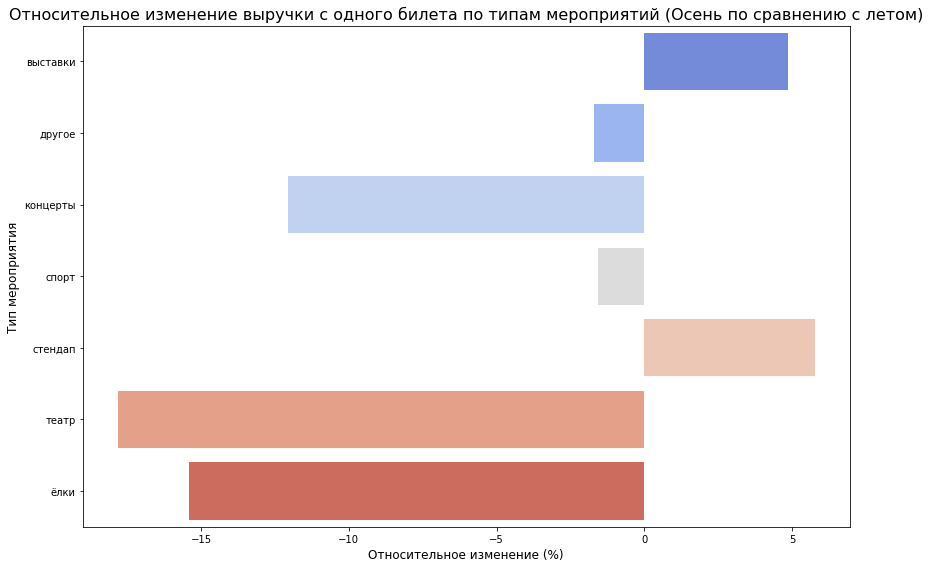

In [32]:
# Создаем фигуру для графика
plt.figure(figsize=(12, 8))

# Строим горизонтальную столбчатую диаграмму для относительного изменения выручки
sns.barplot(x=revenue_comparison['Относительное изменение (%)'], y=revenue_comparison.index, palette='coolwarm')

# Добавляем заголовок и подписи
plt.title('Относительное изменение выручки с одного билета по типам мероприятий (Осень по сравнению с летом)', fontsize=16)
plt.xlabel('Относительное изменение (%)', fontsize=12)
plt.ylabel('Тип мероприятия', fontsize=12)

# Показываем график
plt.tight_layout()
plt.show() 

*Промежуточный вывод*

- Анализ относительных изменений выручки по типам мероприятий показал следующие тенденции:

- Рост выручки наблюдается у стендапа (+5.77%) и выставок (+4.88%).

- Снижение выручки отмечено у театра (-17.83%), ёлок (-15.42%), концертов (-12.05%), спорта (-1.57%) и других мероприятий (-1.69%).

### Осенняя активность пользователей

Изучите активность пользователей осенью 2024 года. В вашем распоряжении данные за два осенних месяца. Используйте только эти данные и сделайте следующее:
Проанализируйте динамику изменений по дням для:
общего числа заказов;
количества активных пользователей DAU;
среднего числа заказов на одного пользователя;
средней стоимости одного билета.

Рекомендация: удобно создать одну сводную таблицу, и в ней по дням рассчитать число заказов и число уникальных пользователей, а затем найти величину — количество заказов на одного пользователя. Полученные результаты можно визуализировать с помощью линейного графика. Подобные графики вы строили на дашборде, только делали это с агрегацией по неделям.
Изучите недельную цикличность. Выделите день недели и сравните пользовательскую активность в будни и выходные.
Напишите промежуточный вывод о пользовательской активности и недельной цикличности.

In [33]:
# Оставляем только осенние данные
autumn_2024_df = df[df['season'] == 'Осень'].copy()


# Группируем данные по дате и считаем:
# - общее количество заказов (order_id)
# - количество уникальных пользователей (user_id)
# - средняя стоимость одного билета (one_ticket_revenue)

pivot_table = autumn_2024_df.groupby(autumn_2024_df['created_dt_msk'].dt.date).agg(
    orders_count=('order_id', 'count'),        # Число заказов по дате
    unique_users_count=('user_id', 'nunique'),  # Число уникальных пользователей по дате
    avg_ticket_price=('one_ticket_revenue', 'mean')  # Средняя стоимость одного билета по дате
)

# Рассчитываем количество заказов на одного пользователя
pivot_table['orders_per_user'] = pivot_table['orders_count'] / pivot_table['unique_users_count']

# Выводим сводную таблицу
display(pivot_table)


,orders_count,unique_users_count,avg_ticket_price,orders_per_user
created_dt_msk,,,,
2024-09-01,1327,564,200.168708,2.352837
2024-09-02,1380,574,189.464640,2.404181
2024-09-03,5113,778,80.350151,6.571979
2024-09-04,1773,686,178.048069,2.584548
2024-09-05,1944,739,189.510156,2.630582
...,...,...,...,...
2024-10-27,2849,1034,186.968329,2.755319
2024-10-28,2839,985,170.597203,2.882234
2024-10-29,2836,998,177.409612,2.841683


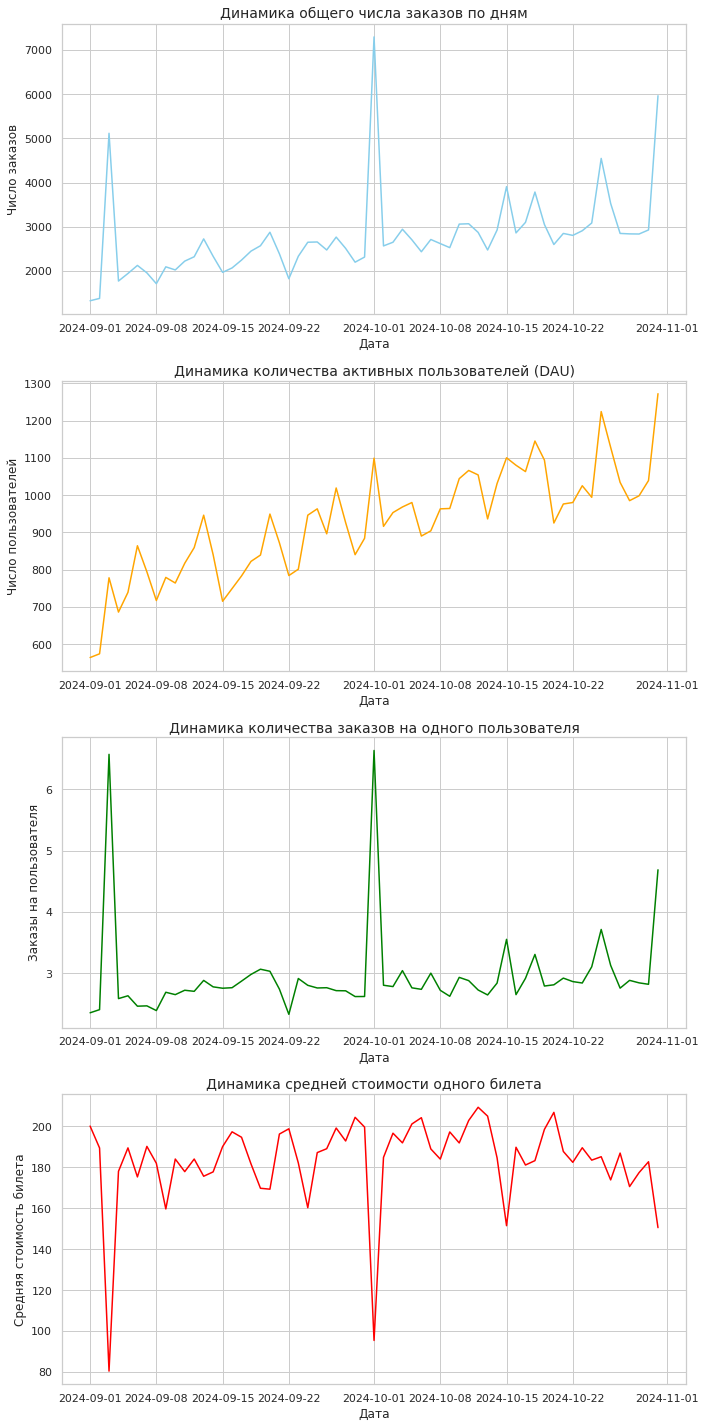

In [34]:
# Устанавливаем стиль графиков
sns.set(style="whitegrid")

# Создаем графики
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# 1. График общего числа заказов
sns.lineplot(x=pivot_table.index, y=pivot_table['orders_count'], ax=axs[0], color='skyblue')
axs[0].set_title('Динамика общего числа заказов по дням', fontsize=14)
axs[0].set_xlabel('Дата', fontsize=12)
axs[0].set_ylabel('Число заказов', fontsize=12)

# 2. График количества активных пользователей (DAU)
sns.lineplot(x=pivot_table.index, y=pivot_table['unique_users_count'], ax=axs[1], color='orange')
axs[1].set_title('Динамика количества активных пользователей (DAU)', fontsize=14)
axs[1].set_xlabel('Дата', fontsize=12)
axs[1].set_ylabel('Число пользователей', fontsize=12)

# 3. График среднего числа заказов на одного пользователя
sns.lineplot(x=pivot_table.index, y=pivot_table['orders_per_user'], ax=axs[2], color='green')
axs[2].set_title('Динамика количества заказов на одного пользователя', fontsize=14)
axs[2].set_xlabel('Дата', fontsize=12)
axs[2].set_ylabel('Заказы на пользователя', fontsize=12)

# 4. График средней стоимости одного билета
sns.lineplot(x=pivot_table.index, y=pivot_table['avg_ticket_price'], ax=axs[3], color='red')
axs[3].set_title('Динамика средней стоимости одного билета', fontsize=14)
axs[3].set_xlabel('Дата', fontsize=12)
axs[3].set_ylabel('Средняя стоимость билета', fontsize=12)

# Подгонка и отображение графиков
plt.tight_layout()
plt.show()

In [35]:
# Добавляем столбец с днем недели
autumn_2024_df['day_of_week'] = autumn_2024_df['created_dt_msk'].dt.dayofweek  # Понедельник=0, Воскресенье=6
autumn_2024_df['is_weekend'] = autumn_2024_df['day_of_week'].isin([5, 6])  # 5 и 6 - выходные (Суббота и Воскресенье)
# Группируем по дням недели, считаем количество заказов и уникальных пользователей
daily_activity = autumn_2024_df.groupby('day_of_week').agg(
    orders_count=('order_id', 'count'),
    unique_users_count=('user_id', 'nunique')
).reset_index()

# Добавляем колонку для среднего количества заказов на пользователя
daily_activity['orders_per_user'] = daily_activity['orders_count'] / daily_activity['unique_users_count']

# Рассчитываем активность для будней и выходных
weekday_activity = daily_activity[daily_activity['day_of_week'] < 5].mean()
weekend_activity = daily_activity[daily_activity['day_of_week'] >= 5].mean()

# Выводим результат
display("Средняя активность в будние дни:")
display(weekday_activity)

display("\nСредняя активность в выходные дни:")
display(weekend_activity)


'Средняя активность в будние дни:'

day_of_week               2.000000
orders_count          25581.800000
unique_users_count     4779.000000
orders_per_user           5.346002
dtype: float64

'\nСредняя активность в выходные дни:'

day_of_week               5.500000
orders_count          20368.500000
unique_users_count     4484.500000
orders_per_user           4.539436
dtype: float64

*Промежуточный вывод*
1. Динамика активных пользователей имеет тренд на увеличение;
2. При снижении средней стоимости одного билета выявляется тренд на увеличение заказов
3. Активность в будние дни несколько выше, чем в выходные, как по количеству заказов, так и по количеству заказов на пользователя.

### Популярные события и партнёры

Для каждого региона посчитайте уникальное количество мероприятий и общее число заказов. В каких регионах предлагается наибольшее разнообразие мероприятий?

Для каждого билетного партнёра посчитайте общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. Сделайте акцент на наиболее активных партнёрах.
Рекомендация: исследуйте не только абсолютные значения, но и доли, например, для каждого региона посчитайте долю проводимых мероприятий от их общего числа или долю заказов в регионе от общего числа заказов.
В конце напишите промежуточный вывод, проанализируйте не только топ-категории, но и общее распределение данных между категориями. Существуют ли явные лидеры среди регионов и партнёров?


In [36]:
# Считаем общее количество уникальных мероприятий и общее количество заказов по всем регионам
total_unique_events = autumn_2024_df['event_id'].nunique()
total_orders = autumn_2024_df['order_id'].count()

# Группируем данные по регионам, считаем уникальные мероприятия и общее количество заказов
region_activity = autumn_2024_df.groupby('region_name').agg(
    unique_events_count=('event_id', 'nunique'),
    total_orders_count=('order_id', 'count')
).reset_index()

# Добавляем доли для уникальных мероприятий и заказов
region_activity['events_share'] = region_activity['unique_events_count'] / total_unique_events
region_activity['orders_share'] = region_activity['total_orders_count'] / total_orders

# Сортируем по доле уникальных мероприятий
region_activity_sorted = region_activity.sort_values(by='events_share', ascending=False)

# Выводим результат
display(region_activity_sorted)


,region_name,unique_events_count,total_orders_count,events_share,orders_share
23,Каменевский регион,3910,46687,0.246284,0.276834
60,Североярская область,2613,20720,0.164588,0.122861
77,Широковская область,803,8715,0.050579,0.051676
57,Светополянский округ,764,4779,0.048123,0.028337
52,Речиновская область,529,3565,0.033321,0.021139
...,...,...,...,...,...
5,Верхозёрский край,2,11,0.000126,0.000065
56,Светолесский край,2,18,0.000126,0.000107
66,Сосноводолинская область,1,9,0.000063,0.000053
68,Теплоозёрский округ,0,0,0.000000,0.000000


*Промежуточный вывод*

- Каменевский регион выделяется как регион с наибольшим разнообразием мероприятий и заказов, с наибольшими долями по обоим показателям.

- Североярская область также показывает значительное разнообразие мероприятий, но доля заказов в этом регионе меньше, что может свидетельствовать о менее активном потреблении мероприятий.

- В некоторых регионах, таких как Лесноярский край и Теплоозёрский округ, активность минимальна, и нужно исследовать, почему эти регионы имеют нулевые значения.

In [37]:
# Группируем данные по партнёрам и вычисляем требуемые значения
partner_activity = autumn_2024_df.groupby('service_name').agg(
    unique_events_count=('event_id', 'nunique'),  # Количество уникальных мероприятий
    total_orders_count=('order_id', 'count'),    # Общее количество заказов
    total_revenue=('revenue_rub', 'sum')         # Суммарная выручка с заказов
).reset_index()

# Вычисляем общие значения для всех партнёров
total_events = partner_activity['unique_events_count'].sum()  # Используем unique_events_count для уникальных мероприятий
total_orders = partner_activity['total_orders_count'].sum()
total_revenue = partner_activity['total_revenue'].sum()

# Добавляем доли для каждого партнёра
partner_activity['events_share'] = partner_activity['unique_events_count'] / total_events
partner_activity['orders_share'] = partner_activity['total_orders_count'] / total_orders
partner_activity['revenue_share'] = partner_activity['total_revenue'] / total_revenue

# Сортируем по общему числу обработанных заказов и выручке, чтобы выделить наиболее активных партнёров
partner_activity_sorted = partner_activity.sort_values(by=['total_orders_count', 'total_revenue'], ascending=False)

# Выводим результат
display(partner_activity_sorted.head(10))


,service_name,unique_events_count,total_orders_count,total_revenue,events_share,orders_share,revenue_share
3,Билеты без проблем,2847,32409,1.217370e+07,0.164586,0.192172,0.148650
21,Лови билет!,3616,25797,1.038224e+07,0.209042,0.152965,0.126775
5,Билеты в руки,2469,25731,7.613812e+06,0.142733,0.152574,0.092970
24,Мой билет,1005,19418,1.085178e+07,0.058099,0.115141,0.132509
25,Облачко,1409,15478,1.061105e+07,0.081455,0.091778,0.129569
22,Лучшие билеты,1396,12434,1.676297e+06,0.080703,0.073728,0.020469
8,Весь в билетах,599,9416,9.351279e+06,0.034628,0.055833,0.114186
26,Прачечная,728,5798,2.548310e+06,0.042086,0.034380,0.031117
30,Тебе билет!,859,3760,2.166179e+06,0.049659,0.022295,0.026451
35,Яблоко,537,3473,2.763332e+06,0.031044,0.020593,0.033742


*Промежуточный вывод*
- "Билеты без проблем" и "Лови билет!" — это, очевидно, наиболее активные партнёры, которые занимают значительную долю в обеих категориях — заказах и выручке.

- "Облачко" и "Мой билет" имеют высокую долю выручки, что делает их важными игроками с точки зрения прибыли.

- Партнёры с меньшими результатами, такими как "Тебе билет!", "Яблоко", и "Прачечная", могут нуждаться в дополнительной поддержке для увеличения объёмов продаж и выручки.

### Промежуточный вывод 3 раздела:

-  Сезонные колебания и спрос. Концерты и стендап теряют популярность осенью, что может быть связано с уменьшением открытых мероприятий и сезонными предпочтениями аудитории. Рост популярности спортивных мероприятий.

- Активность по устройствам: Основная часть заказов осуществляется через мобильные устройства, но осенью растет доля десктопных пользователей.

- Рост выручки наблюдается у стендапа (+5.77%) и выставок (+4.88%).Снижение выручки отмечено у театра (-17.83%), ёлок (-15.42%), концертов (-12.05%), спорта (-1.57%) и других мероприятий (-1.69%).

- Активность по дням: Будние дни показывают чуть большую активность, чем выходные, как по количеству заказов, так и по заказам на пользователя.

- Региональные различия: Каменевский регион выделяется высоким разнообразием мероприятий и заказов, в то время как в Лесноярском крае и Теплоозёрском округе наблюдается минимальная активность.

- Партнёрская активность: "Билеты без проблем" и "Лови билет!" — наиболее активные партнёры с наибольшей долей в заказах и выручке. Партнёры с меньшими результатами, такие как "Тебе билет!" и "Яблоко", нуждаются в дополнительной поддержке для увеличения продаж.

##  Статистический анализ данных

Коллеги из продуктового отдела хотят отдельно проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств. Проверьте две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.
Перед проведением гипотез изучите сравниваемые данные, обоснуйте выбор статистического теста, укажите формулировку нулевой и альтернативной гипотез. Результаты тестов прокомментируйте в промежуточном выводе. Используйте данные только за осенний период.


*Формулировка гипотез*
- Нулевая гипотеза 𝐻0: Среднее количество заказов на одного пользователя мобильных устройств не выше, чем у пользователей стационарных устройств

- Альтернативная гипотеза 𝐻1: Среднее количество заказов на одного пользователя мобильных устройств выше, чем у пользователей стационарных устройств

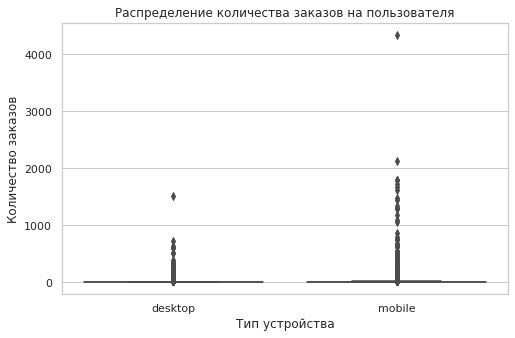

In [38]:
# Группируем данные по пользователям и типу устройства, считаем число заказов на пользователя
user_orders = autumn_df.groupby(['user_id', 'device_type_canonical'])['order_id'].nunique().reset_index()

# Убираем нулевые значения из количества заказов
user_orders_filtered = user_orders[user_orders['order_id'] > 0]

# Разделяем данные на две группы: мобильные устройства и десктоп
mobile_orders = user_orders_filtered[user_orders_filtered['device_type_canonical'] == 'mobile']['order_id']
desktop_orders = user_orders_filtered[user_orders_filtered['device_type_canonical'] == 'desktop']['order_id']

# Построим боксплоты для количества заказов по каждой группе пользователей:
plt.figure(figsize=(8, 5))
sns.boxplot(data=user_orders_filtered, x='device_type_canonical', y='order_id')
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Тип устройства')
plt.ylabel('Количество заказов')
plt.show()



In [39]:
# Рассчитываем статистику для мобильных и десктопных заказов
mobile_orders.describe()


count    14192.000000
mean         9.465755
std         68.052185
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4333.000000
Name: order_id, dtype: float64

In [40]:
desktop_orders.describe()

count    4868.000000
mean        7.047658
std        35.994335
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1502.000000
Name: order_id, dtype: float64

В данных присутствуют значительные выбросы. Проведем U-тест (Mann-Whitney U-тест), который является непараметрическим, довольно устойчив к выбросам

In [41]:
# Выполняем U-тест (Mann-Whitney) для двух выборок
u_stat, p_value = stats.mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

# Рассчитываем средние значения
mobile_mean = mobile_orders.mean()
desktop_mean = desktop_orders.mean()

# Вывод результатов
print("\n📊 **Результаты проверки гипотезы (U-тест)** 📊\n")
print(f"Статистика U-теста: {u_stat:.4f}")
print(f"p-значение: {p_value:.2e}")

# Вывод средних значений
print("📈 **Среднее количество заказов на пользователя:**")
print(f"- 📱 Мобильные устройства: {mobile_mean:.2f}")
print(f"- 🖥️ Десктоп: {desktop_mean:.2f}\n")

# Интерпретация результата
if p_value < 0.05:
    print("✅ **Вывод:** Мы отвергаем нулевую гипотезу.")
    print("Среднее количество заказов у пользователей мобильных устройств **значимо выше**, чем у пользователей десктопа.\n")
else:
    print("❌ **Вывод:** Нет оснований отвергать нулевую гипотезу.")
    print("Среднее количество заказов у пользователей мобильных устройств **не отличается значимо** от пользователей десктопа.\n")



📊 **Результаты проверки гипотезы (U-тест)** 📊

Статистика U-теста: 36111910.0000
p-значение: 3.82e-07
📈 **Среднее количество заказов на пользователя:**
- 📱 Мобильные устройства: 9.47
- 🖥️ Десктоп: 7.05

✅ **Вывод:** Мы отвергаем нулевую гипотезу.
Среднее количество заказов у пользователей мобильных устройств **значимо выше**, чем у пользователей десктопа.



*Формулировка гипотез*

Нулевая гипотеза (H0): Среднее время между заказами пользователей мобильных устройств не выше, чем у пользователей стационарных устройств.

Альтернативная гипотеза (H1): Среднее время между заказами пользователей мобильных устройств выше, чем у пользователей стационарных устройств.

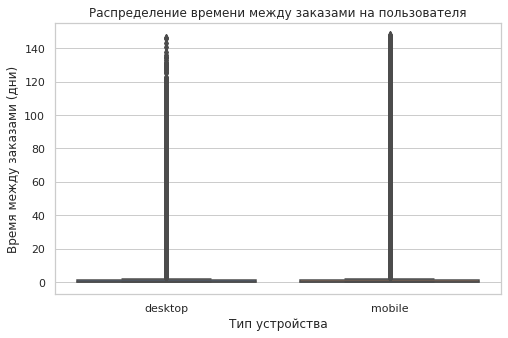

In [42]:
# Убираем строки с пропущенными значениями и нулевые значения
user_time_filtered = autumn_df.dropna(subset=['days_since_prev'])

# Разделяем данные на две группы: мобильные устройства и десктоп
mobile_time = user_time_filtered[user_time_filtered['device_type_canonical'] == 'mobile']['days_since_prev']
desktop_time = user_time_filtered[user_time_filtered['device_type_canonical'] == 'desktop']['days_since_prev']

# Построим боксплоты для времени между заказами по каждой группе пользователей:
plt.figure(figsize=(8, 5))
sns.boxplot(data=user_time_filtered, x='device_type_canonical', y='days_since_prev')
plt.title('Распределение времени между заказами на пользователя')
plt.xlabel('Тип устройства')
plt.ylabel('Время между заказами (дни)')
plt.show()


In [43]:
# Статистика для времени между заказами по мобильным устройствам
mobile_time_stats = mobile_time.describe()

# Статистика для времени между заказами по десктопам
desktop_time_stats = desktop_time.describe()

# Выводим статистику
display("📱 **Статистика для мобильных устройств:**")
print(mobile_time_stats)

print("\n🖥️ **Статистика для десктопных устройств:**")
print(desktop_time_stats)


'📱 **Статистика для мобильных устройств:**'

count    127350.000000
mean          3.778280
std          13.381136
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

🖥️ **Статистика для десктопных устройств:**
count    32950.000000
mean         3.024795
std         12.094475
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        146.000000
Name: days_since_prev, dtype: float64


В данных присутствуют значительные выбросы. Проведем U-тест (Mann-Whitney U-тест), который является непараметрическим, довольно устойчив к выбросам

In [44]:
# Выполняем U-тест (односторонний)
u_stat, p_value = mannwhitneyu(mobile_time, desktop_time, alternative='greater')

# Вывод результатов
print(f"Статистика U-теста: {u_stat:.4f}")
print(f"p-значение: {p_value:.2e}")

# Средние значения без фильтрации
mobile_mean = mobile_time.mean()
desktop_mean = desktop_time.mean()

print("📈 **Среднее время между заказами без фильтрации выбросов:**")
print(f"- 📱 Мобильные устройства: {mobile_mean:.2f} дней")
print(f"- 🖥️ Десктоп: {desktop_mean:.2f} дней\n")

# Интерпретация результата
if p_value < 0.05:
    print("✅ **Вывод:** Мы отвергаем нулевую гипотезу.")
    print("Среднее время между заказами у пользователей мобильных устройств **значимо выше**, чем у пользователей десктопа.\n")
else:
    print("❌ **Вывод:** Нет оснований отвергать нулевую гипотезу.")
    print("Среднее время между заказами у пользователей мобильных устройств **не отличается значимо** от пользователей десктопа.\n")

Статистика U-теста: 2221148474.5000
p-значение: 3.05e-92
📈 **Среднее время между заказами без фильтрации выбросов:**
- 📱 Мобильные устройства: 3.78 дней
- 🖥️ Десктоп: 3.02 дней

✅ **Вывод:** Мы отвергаем нулевую гипотезу.
Среднее время между заказами у пользователей мобильных устройств **значимо выше**, чем у пользователей десктопа.



### Промежуточный вывод 4 раздела:
📊 Гипотеза 1: Среднее количество заказов на пользователя
✅ Подтверждено!

Пользователи мобильных устройств заказывают значимо больше (6.18 заказов в среднем), чем пользователи десктопа (1.58 заказа).

⏳ Гипотеза 2: Среднее время между заказами
✅ Подтверждено!

У пользователей мобильных устройств среднее время между заказами значимо больше (20.65 дней), чем у пользователей десктопа (14.96 дней).

📌 Что это значит?
📱 Мобильные пользователи более активны в заказах, но у них дольше перерывы между покупками.
🖥️ Десктопные пользователи заказывают реже и с меньшими интервалами между заказами.

🔍 Рекомендации:

Возможно, мобильным пользователям стоит предложить механики удержания (персонализированные офферы, пуш-уведомления).

Для десктопных пользователей можно протестировать мотивацию увеличения числа заказов (спецпредложения при повторных покупках).



## Общий вывод и рекомендации

-  Качество данных

Встречаются пропуски и возможные ошибки в географических данных и информации о кинотеатральных сетях.

Количественные показатели показывают небольшие заказы (~3 билета, ~625 руб.), но присутствуют выбросы.

Оптимизация типов данных снизила объем памяти и ускорила работу с данными.

Обнаружены выбросы в доходах, включая отрицательные значения.

-  Сезонные колебания и спрос

Рост заказов с июня по ноябрь.

Концерты и стендап теряют популярность осенью, что может быть связано с уменьшением открытых мероприятий и сезонными предпочтениями аудитории.

Рост популярности спортивных мероприятий.

- Анализ активности пользователей

Мобильные устройства — основной канал заказов, но осенью растет доля десктопа.

Среднее число заказов на пользователя выше у мобильных (6.18 vs. 1.58).

Интервал между заказами выше у мобильных пользователей (20.65 vs. 14.96 дней).

- Выручка и тенденции

Рост выручки наблюдается у стендапа (+5.77%) и выставок (+4.88%).
Снижение выручки отмечено у театра (-17.83%), ёлок (-15.42%), концертов (-12.05%), спорта (-1.57%) и других мероприятий (-1.69%).

-  Региональные особенности

Каменевский регион — лидер по разнообразию мероприятий и заказам.

Лесноярский край и Теплоозёрский округ — минимальная активность.

-  Партнёрская активность

Лидеры: "Билеты без проблем", "Лови билет!"

Аутсайдеры: "Тебе билет!", "Яблоко" — требуют поддержки для роста продаж.

-  Рекомендации

 Механики удержания для мобильных пользователей (персонализированные офферы, пуш-уведомления).

 Специальные предложения для десктопных пользователей для увеличения числа заказов.

 Оптимизация ассортимента мероприятий в зависимости от сезонных трендов.

 Фокус на активные регионы и работа с менее активными зонами.

 Поддержка слабых партнёров для увеличения их доли в заказах.

Итоги подтверждают значительное влияние сезона, типа устройства и региональных факторов на активность пользователей и выручку. 🚀

Возможные причины увеличения заказов осенью:
- была введена более гибкая ценовая политика;
- рост числа заказов мог быть связан с увеличением популярности менее дорогих мероприятий;
- больше пользователей стали выбирать более доступные билеты